# Fraud Detection & Monitoring (PaySim)

**Goal:** Build a baseline fraud detection model and choose an alert threshold that fits a realistic review capacity.

**Dataset:** PaySim synthetic mobile money transactions. Target variable: `isFraud`.


## Data scope

Fraud in PaySim is concentrated in specific transaction types.  
To build a strong baseline and reduce noise, we focus on `TRANSFER` and `CASH_OUT` (the main fraud-driving types) in this notebook.


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_fscore_support
from sklearn.metrics import precision_recall_fscore_support

DATA_PATH = "../data/paysim.csv"
FOCUS_TYPES = ["TRANSFER", "CASH_OUT"]
TARGET = "isFraud"

df = pd.read_csv(DATA_PATH)
df = df[df["type"].isin(FOCUS_TYPES)].copy()

print("Shape:", df.shape)
print("Fraud rate:", df[TARGET].mean(), f"({df[TARGET].mean()*100:.4f}%)")


Shape: (2770409, 11)
Fraud rate: 0.002964544224336551 (0.2965%)


## Train/test split (time-based)

To mimic a real production setup, we split by time (`step`): train on earlier transactions and evaluate on later ones.  
This avoids leakage that can happen with random splits in temporal data.


In [18]:
# Sort by time (step) and split chronologically (80% train / 20% test)
df = df.sort_values("step").reset_index(drop=True)

split_step = int(df["step"].quantile(0.80))

train = df[df["step"] <= split_step].copy()
test  = df[df["step"] >  split_step].copy()

print("Split step:", split_step)
print(f"Train: {train.shape} | Fraud rate: {train[TARGET].mean():.6f}")
print(f"Test : {test.shape} | Fraud rate: {test[TARGET].mean():.6f}")


Split step: 354
Train: (2217905, 11) | Fraud rate: 0.001783
Test : (552504, 11) | Fraud rate: 0.007707


Note: Fraud prevalence increases in the later period, making the evaluation more realistic and more challenging.


## Baseline model (Logistic Regression)

We build a simple, interpretable baseline using Logistic Regression.  
Categorical feature `type` is one-hot encoded, numeric features are passed through.  
Because fraud is rare, we use `class_weight="balanced"` and evaluate with **ROC-AUC** and **PR-AUC** (more informative under class imbalance).


In [22]:
# Features / target
feature_cols = [
    "type", "amount",
    "oldbalanceOrg", "newbalanceOrig",
    "oldbalanceDest", "newbalanceDest"
]

X_train = train[feature_cols]
y_train = train[TARGET]

X_test  = test[feature_cols]
y_test  = test[TARGET]

# Preprocess: one-hot for categorical, passthrough for numeric
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), ["type"]),
        ("num", "passthrough", ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]),
    ]
)

model = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=300, class_weight="balanced"))
])

model.fit(X_train, y_train)

proba = model.predict_proba(X_test)[:, 1]
print(f"ROC-AUC: {roc_auc_score(y_test, proba):.4f}")
print(f"PR-AUC : {average_precision_score(y_test, proba):.4f}")


ROC-AUC: 0.9821
PR-AUC : 0.7250


## Threshold tuning (alert volume vs. quality)

In practice, fraud models are used to generate **alerts** for manual review.  
A lower threshold increases **recall** (catch more fraud) but also creates many more alerts (lower **precision**).

Below we evaluate a few thresholds and report:
- **precision**: % of alerts that are truly fraud
- **recall**: % of fraud we catch
- **F1**: balance of precision/recall
- **alerts_predicted**: how many cases would be sent to review


In [32]:
thresholds = [0.50, 0.30, 0.20, 0.10, 0.05]
rows = []

for t in thresholds:
    pred = (proba >= t).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(
        y_test, pred, average="binary", zero_division=0
    )
    rows.append((t, p, r, f1, int(pred.sum())))

result = pd.DataFrame(rows, columns=["threshold", "precision", "recall", "f1", "alerts_predicted"])
result


,threshold,precision,recall,f1,alerts_predicted
0,0.50,0.113717,0.915688,0.202309,34287
1,0.30,0.050849,0.984265,0.096702,82421
2,0.20,0.033355,0.989197,0.064534,126278
3,0.10,0.022362,0.993189,0.043739,189117
4,0.05,0.017387,0.993894,0.034176,243399


## Monitoring (test period): Model score over time

We track the model’s **average fraud score** over time on the **future (test) period**.  
A rolling mean is used to reduce noise and reveal trend changes that could indicate **data drift** or behavior shifts.


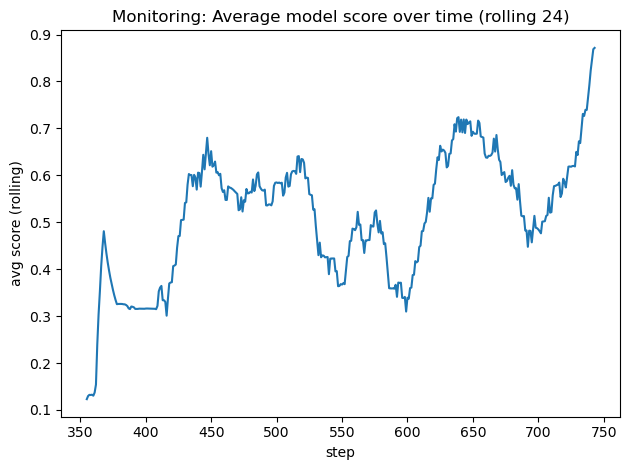

In [29]:
# Monitoring view on the test period: score + alert volume over time

monitor = test.copy()
monitor["score"] = proba

by_step = monitor.groupby("step").agg(
    avg_score=("score", "mean"),
    tx_count=("score", "size")
).reset_index()

# Smooth trend (rolling window)
window = 24
by_step["avg_score_roll"] = by_step["avg_score"].rolling(window, min_periods=1).mean()

plt.figure()
plt.plot(by_step["step"], by_step["avg_score_roll"])
plt.title(f"Monitoring: Average model score over time (rolling {window})")
plt.xlabel("step")
plt.ylabel("avg score (rolling)")
plt.tight_layout()
plt.savefig("../reports/figures/monitor_avg_score_roll.png", dpi=150)
plt.show()


### Key takeaway

The average fraud score fluctuates across time steps, so the model remains sensitive to changing transaction patterns in the test period.  
If we see a sustained upward/downward shift in this curve in production, it can be an early signal of **data drift** and should trigger model/threshold review.


## Alert policy: Review-capacity based threshold + alert volume

In production, fraud teams review only a limited number of cases.  
We simulate this by flagging the **top 1% highest scores** as alerts (quantile-based threshold) and monitor the **alert volume over time**.  
This connects model output to a realistic operational constraint (**review capacity**).


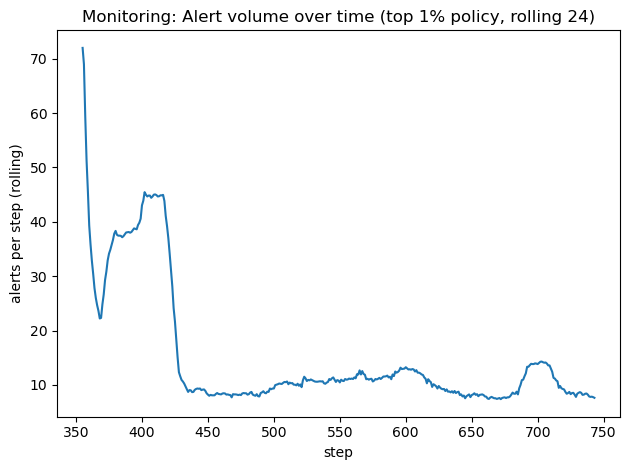

Alert threshold (q=0.99): 0.916627
Total alerts in test: 5526


In [30]:
# Alert policy: top 1% scores become alerts + alert volume monitoring

q = 0.99
threshold = float(pd.Series(proba).quantile(q))
monitor = test.copy()
monitor["score"] = proba
monitor["alert"] = (monitor["score"] >= threshold).astype(int)

by_step = monitor.groupby("step").agg(
    alerts=("alert", "sum")
).reset_index()

window = 24
by_step["alerts_roll"] = by_step["alerts"].rolling(window, min_periods=1).mean()

plt.figure()
plt.plot(by_step["step"], by_step["alerts_roll"])
plt.title(f"Monitoring: Alert volume over time (top {(1-q)*100:.0f}% policy, rolling {window})")
plt.xlabel("step")
plt.ylabel("alerts per step (rolling)")
plt.tight_layout()
plt.savefig("../reports/figures/monitor_alerts_roll.png", dpi=150)
plt.show()

print(f"Alert threshold (q={q}): {threshold:.6f}")
print(f"Total alerts in test: {int(monitor['alert'].sum())}")


**Key takeaway**
- A fixed “top 1%” alert policy keeps review workload predictable, but alert volume still changes over time.
- Spikes indicate periods where customer behavior or transaction mix shifts (potential drift).
- In production, this plot helps adjust thresholds or routing rules to keep the review queue stable.


In [31]:
result


,threshold,precision,recall,f1,alerts_predicted
0,0.50,0.113717,0.915688,0.202309,34287
1,0.30,0.050849,0.984265,0.096702,82421
2,0.20,0.033355,0.989197,0.064534,126278
3,0.10,0.022362,0.993189,0.043739,189117
4,0.05,0.017387,0.993894,0.034176,243399


### Key takeaway

Lower thresholds produce extremely high recall but overwhelm operations with too many alerts.  
This table makes the trade-off explicit: we choose a threshold based on **review capacity**, not just “best” metrics.


## Threshold sweep: precision/recall vs. alert volume

We evaluate several probability thresholds to make the operational trade-off explicit:
higher thresholds reduce alert volume (review workload) but may miss more fraud (lower recall).


In [35]:
thresholds = [0.99, 0.97, 0.95, 0.93, 0.90, 0.85, 0.80]
rows = []

for t in thresholds:
    pred = (proba >= t).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(y_test, pred, average="binary", zero_division=0)
    rows.append((t, p, r, f1, int(pred.sum())))

result = pd.DataFrame(rows, columns=["threshold", "precision", "recall", "f1", "alerts_predicted"])
result


,threshold,precision,recall,f1,alerts_predicted
0,0.99,0.842862,0.550493,0.666004,2781
1,0.97,0.722359,0.618365,0.666329,3645
2,0.95,0.645853,0.658290,0.652012,4340
3,0.93,0.581714,0.688821,0.630753,5042
4,0.90,0.501306,0.720996,0.591408,6124
5,0.85,0.409497,0.775716,0.536027,8066
6,0.80,0.332600,0.816815,0.472715,10457


**Interpretation:** This table is used to select a threshold based on realistic review capacity, not just on model metrics.


## Alert policy: Top 1% scores as alerts (capacity-based threshold)

In practice, fraud teams can only review a limited number of cases per day.  
We simulate this by flagging the top 1% highest-risk transactions in the test period as alerts and report the resulting precision/recall and alert volume.


In [36]:
q = 0.99  # top 1% as alerts (capacity policy)

t = float(pd.Series(proba).quantile(q))
pred = (proba >= t).astype(int)

p, r, f1, _ = precision_recall_fscore_support(y_test, pred, average="binary", zero_division=0)

print(f"Policy: top {(1-q)*100:.0f}% as alerts (q={q})")
print(f"Chosen threshold (quantile): {t:.6f}")
print(f"Alerts predicted: {int(pred.sum())}")
print(f"Precision: {p:.3f} | Recall: {r:.3f} | F1: {f1:.3f}")


Policy: top 1% as alerts (q=0.99)
Chosen threshold (quantile): 0.916627
Alerts predicted: 5526
Precision: 0.543 | Recall: 0.704 | F1: 0.613


**Key takeaway:** This converts model scores into an operational decision rule.  
We choose the threshold based on review capacity, then measure how much fraud we catch (recall) and how many alerts are true fraud (precision).


## Operating point (capacity-based)

We pick an operating point based on review capacity: flag the **top 1%** highest-risk transactions as alerts, then report precision/recall/F1 and alert volume.


In [37]:
# Operating point: review capacity = top 1% highest-risk transactions
q = 0.99
threshold = float(pd.Series(proba).quantile(q))
pred = (proba >= threshold).astype(int)

p, r, f1, _ = precision_recall_fscore_support(
    y_test, pred, average="binary", zero_division=0
)

alerts = int(pred.sum())

print(f"Operating point: top {(1-q)*100:.0f}% alerts (q={q})")
print(f"Threshold: {threshold:.6f}")
print(f"Alerts predicted: {alerts}")
print(f"Precision: {p:.3f} | Recall: {r:.3f} | F1: {f1:.3f}")


Operating point: top 1% alerts (q=0.99)
Threshold: 0.916627
Alerts predicted: 5526
Precision: 0.543 | Recall: 0.704 | F1: 0.613


## Monitoring: alert rate over time (test period)

We monitor how often transactions are flagged as alerts over time (test period).  
A rolling mean smooths noise and helps spot regime changes / potential drift.


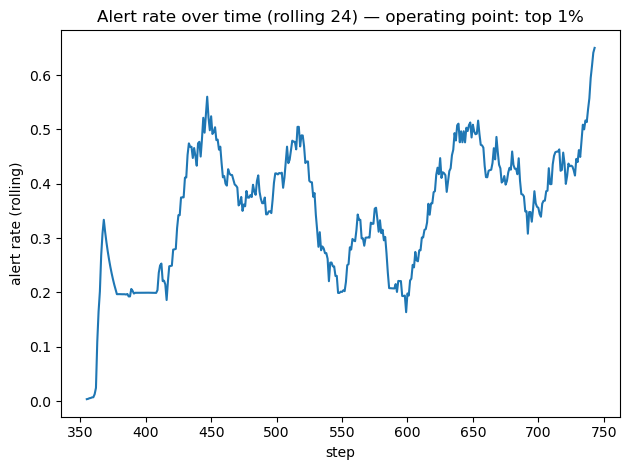

Total alerts in test: 5526


In [39]:
# Monitoring: alert rate over time (test period) at the chosen operating threshold
monitor = test.copy()
monitor["score"] = proba
monitor["alert"] = (monitor["score"] >= threshold).astype(int)

by_step = (
    monitor.groupby("step")["alert"]
    .mean()
    .reset_index(name="alert_rate")
)

# Smooth with a rolling window (e.g., 24 steps)
window = 24
by_step["alert_rate_roll"] = by_step["alert_rate"].rolling(window, min_periods=1).mean()

plt.figure()
plt.plot(by_step["step"], by_step["alert_rate_roll"])
plt.title(f"Alert rate over time (rolling {window}) — operating point: top 1%")
plt.xlabel("step")
plt.ylabel("alert rate (rolling)")
plt.tight_layout()
plt.savefig("../reports/figures/monitor_alert_rate_roll.png", dpi=150)
plt.show()

print(f"Total alerts in test: {int(monitor['alert'].sum())}")


## Summary (key outputs)

**Goal:** Build a baseline fraud detection model and choose an alert threshold aligned with realistic review capacity.

### What we did
- **Time-based split** using `step` to mimic production (train on past, test on future)
- Focused on high-risk transaction types: **TRANSFER** and **CASH_OUT**
- Trained a **Logistic Regression** baseline with `class_weight="balanced"`

### Model performance (test set)
- **ROC-AUC:** ~0.98  
- **PR-AUC:** ~0.72  *(more informative under class imbalance)*

### Operating point (review-capacity driven)
- Selected **top 1% scores** as alerts (threshold ~0.92)
- **Precision:** ~0.54  
- **Recall:** ~0.70  
- **Total alerts in test:** 5,526

### Monitoring view
- Produced a **rolling alert-rate over time** plot to support drift monitoring during the test period.

### Notes / next steps
- Add feature engineering and stronger models (e.g., tree-based)
- Calibrate probabilities and evaluate cost-aware thresholds
- Add backtesting + simple alert-volume dashboards for operations
